In [1]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
import os
import importlib
import warnings
warnings.filterwarnings("ignore")
os.chdir(r'E:\AAA_Labwork\Tcell tissues\v2')
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

import re
from gprofiler import GProfiler
import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
#This pallete is for colorblinds
my_palette = ['#0351A8','#8CB0E0','#D56D11','#FFBB78','#234E08','#53CB8B','#D30083','#CB788D','#4E195A','#C58CCF','#AA290F','#B03FD1','#E8BCCF','#64605F','#B2AD9A','#D2D30B','#D1BD4F','#06DCF2','#9EDAE5','#517219','#5B43CF','#D92F24','#FFD900','#002F33','#B8A3A3']

In [4]:
from matplotlib.colors import LinearSegmentedColormap
values = [0, 1]
colors = [(227, 227, 227), (255, 42, 18)]
colors = [tuple(np.array(color) / 255) for color in colors]
my_cmap = LinearSegmentedColormap.from_list('', colors)

In [5]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)

In [6]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths('C:\\Users\\16220\\AppData\\Local\\R\\win-library\\4.3'))

# Load all the R libraries we will be using in the notebook
library(scran)
library(Matrix)
library(Seurat)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(ggplot2)
library(plyr)
library(MAST)
library(clusterExperiment)
library(SingleCellExperiment)
library(monocle3)
library(destiny)
library(circlize)

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000164F590F4C0>:
Traceback (most recent call last):
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 0: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000164F590F4C0>:
Traceback (most recent call last):
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Exception ignored from cffi callback <function _consolewrite_ex at 0x00000164F590F4C0>:
Traceback (most recent call last):
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x00000164F590F4C0>:
Traceback (most recent call last):
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "c:\Users\16220\anaconda3\envs\cpdb\lib\site-packages\rpy2\rinterface_lib\

In [7]:
adata_gut = sc.read_h5ad(r"gut_annotated.h5ad")
adata_liver = sc.read_h5ad(r"liver_annotated.h5ad")

### answer the question of what cell types contributes to the donor T/mac difference

In [8]:
adata_DEG_gut_T = adata_gut[(adata_gut.obs['celltype_lowres'].isin(['T Cells']))&(adata_gut.obs['batch'].isin(['3','4']))]
adata_DEG_gut_Mac = adata_gut[(adata_gut.obs['celltype_lowres'].isin(['Macrophages']))&(adata_gut.obs['batch'].isin(['3','4']))]

In [9]:
adata_DEG_liver_T = adata_liver[(adata_liver.obs['celltype_lowres'].isin(['T Cells']))&(adata_liver.obs['batch'].isin(['3','4']))]
adata_DEG_liver_Mac = adata_liver[(adata_liver.obs['celltype_lowres'].isin(['Macrophages']))&(adata_liver.obs['batch'].isin(['3','4']))]

In [10]:
adata_list = [adata_DEG_gut_T,adata_DEG_gut_Mac,adata_DEG_liver_T,adata_DEG_liver_Mac]

In [24]:
names = ['gutT','gutMac','liverT','liverMac']
for ind, i in enumerate(adata_list):
    colnames = i.obs_names
    rownames = i.var_names
    counts = i.layers['counts'].T
    counts[np.isnan(counts.A)] = 0

    donorID = i.obs['Donor ID']
    name = names[ind]

    %R setwd('E:/AAA_Labwork/Tcell tissues/v2')
    %R -i counts -i colnames -i rownames -i donorID -i name
    %R colnames(counts) = colnames
    %R rownames(counts) = rownames
    %R srat <- CreateSeuratObject(counts = counts,project = name, min.cells = 0, min.features = 0)
    %R srat[['DonorID']] = donorID
    %R saveRDS(srat, file = name)


In [29]:
adata_gut.obs['Donor ID']

AAACCTGAGCGTGAAC-1-3    Donor AJD3280
AAACCTGAGCTTCGCG-1-3    Donor AJD3280
AAACCTGAGTATGACA-1-3    Donor AJD3280
AAACCTGAGTTGAGAT-1-3    Donor AJD3280
AAACCTGCACGTAAGG-1-3    Donor AJD3280
                            ...      
TTTGGTTTCTCGATGA-1-5    Donor AJKQ118
TTTGTCAAGGCATGGT-1-5    Donor AJKQ118
TTTGTCACACGAGGTA-1-5    Donor AJKQ118
TTTGTCACAGTCCTTC-1-5    Donor AJKQ118
TTTGTCATCGCACTCT-1-5    Donor AJKQ118
Name: Donor ID, Length: 14218, dtype: category
Categories (3, object): ['Donor AJD3280', 'Donor AJG2309', 'Donor AJKQ118']

visualize the results

In [26]:
terms = pd.read_csv('gutT_DEG.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

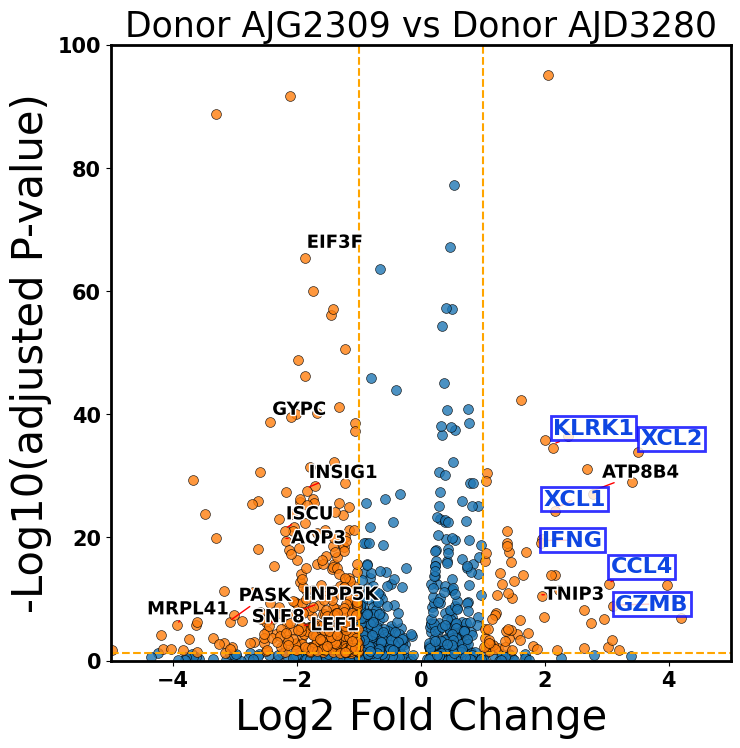

In [31]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Donor AJG2309 vs Donor AJD3280',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*1.8)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*1.8)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.8:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,100])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('gutT_DEG.png')
#plt.show()

In [33]:
terms = pd.read_csv('gutMac_DEG.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

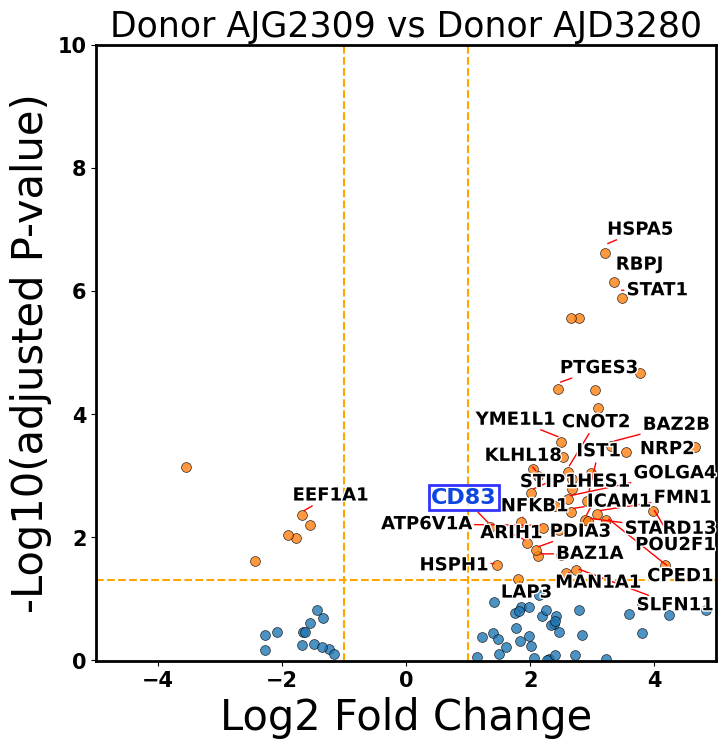

In [40]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Donor AJG2309 vs Donor AJD3280',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG')))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.3:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,10])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('gutMac_DEG.png')
#plt.show()

In [41]:
terms = pd.read_csv('liverT_DEG.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

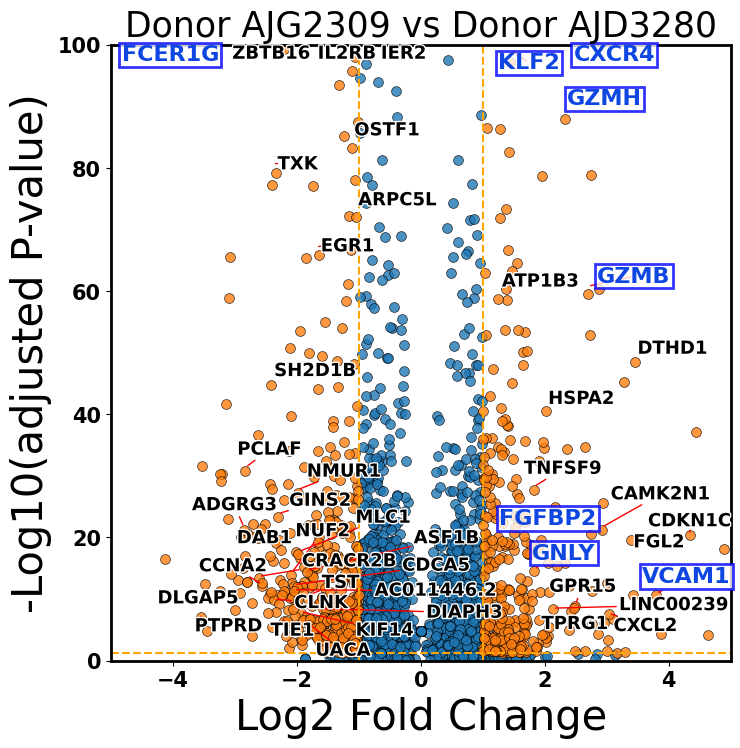

In [42]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Donor AJG2309 vs Donor AJD3280',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*1.8)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<50))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*1.8)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<50))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.8:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
plt.ylim([-0.01,100])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('liverT_DEG.png')
#plt.show()

In [43]:
terms = pd.read_csv('liverMac_DEG.csv')
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]

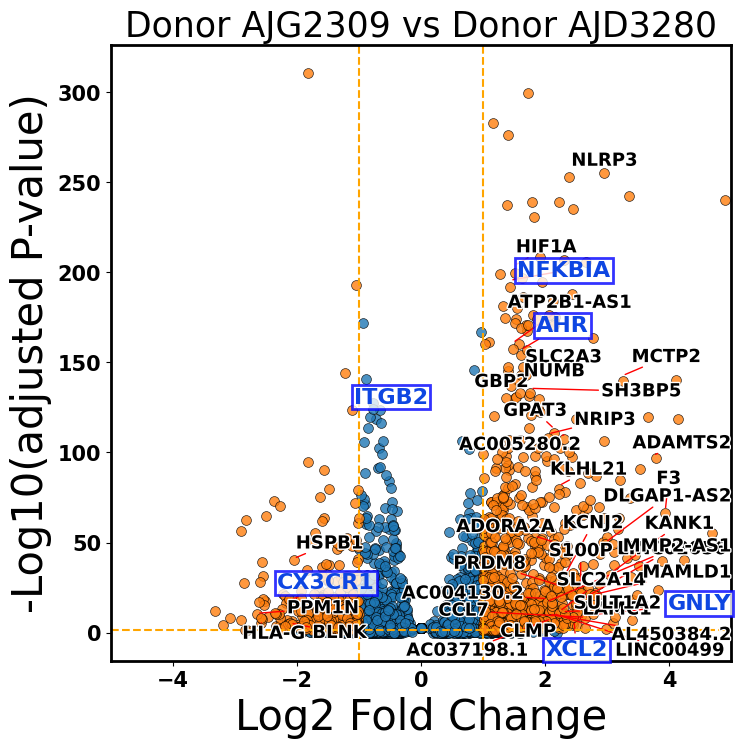

In [50]:
# Volcano plot of results
from adjustText import adjust_text
import matplotlib.patheffects as pe
terms['-logQ'] = -np.log10(terms['q_value'])
terms = terms[terms['-logQ']>0]
fc_thresh = 1
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams.update({'font.size': 14, 'font.weight': 'bold','axes.linewidth':2})
lowqval_de = terms[np.array(terms['-logQ']>=-np.log10(0.05)) & np.array(abs(terms['normalized_effect'])>=fc_thresh)]
other_de = terms[np.array(terms['-logQ']<-np.log10(0.05)) | np.array(abs(terms['normalized_effect'])<fc_thresh)] #actually that's other genes (non sig de)

fig, ax = plt.subplots()
sb.regplot(other_de['normalized_effect'], other_de['-logQ'], fit_reg=False, scatter_kws={'s':50, 'edgecolors': 'black', 'linewidths': 0.5})
sb.regplot(lowqval_de['normalized_effect'], lowqval_de['-logQ'], fit_reg=False, scatter_kws={'s':50,'edgecolors': 'black', 'linewidths': 0.5})
ax.set_xlabel("Log2 Fold Change", fontsize=30)
ax.set_ylabel("-Log10(adjusted P-value)", fontsize=30)
ax.tick_params(labelsize=15)
ax.set_title('Donor AJG2309 vs Donor AJD3280',size = 25)
    
    
    
# Label names and positions
x = [i for i in lowqval_de['normalized_effect']]
y = [i*1.02 for i in lowqval_de['-logQ']]
labels = lowqval_de['gene_short_name']
# Show only some labels to avoid overcrowding the figure
to_keep = np.where((np.array(lowqval_de['gene_short_name'].str.startswith('RP'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('MT'))
                    |np.array(lowqval_de['gene_short_name'].str.startswith('IG'))
                     |(np.array(lowqval_de['normalized_effect']<fc_thresh*2)
                       &np.array(lowqval_de['normalized_effect']>0)
                           &np.array(lowqval_de['-logQ']<100))
                    |(np.array(abs(lowqval_de['normalized_effect'])<fc_thresh*2)
                      &np.array(lowqval_de['normalized_effect']<0)
                           &np.array(lowqval_de['-logQ']<100))
                   |np.array(lowqval_de['-logQ']<5))==0)

labels = labels.iloc[to_keep]
texts = []
important_list = ['GZMB','GNLY','NKG7','GZMH','CD74','VCAM1','KLF2','CTLA4','ITGB2','IFNG',
               'ZNF683','FCER1G','GZMK','KLRG1','FGFBP2','FCGR3A','IL7R','PDCD1','CCL4','KLRK1','IL22','IL23R','IL4','IL10',
              'CD81','CD82','CD83','NFKBIA','HAVCR2','ITGAE','ITGA1','TIGIT','XCL1','XCL2','AHR','SELL','CCL4','CCL5','CCL3','CX3CR1','CXCR3','EOMES','CXCR4','CXCR6','IL2']
for i,txt in enumerate(labels):
    if txt not in important_list:
        if np.random.rand(1) >= 0.9:
            texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 13, color= '#000000', weight = 'bold', path_effects=[pe.withStroke(linewidth=2, foreground="white")]))
    
for i,txt in enumerate(labels):    
    if txt in important_list:
        texts.append(ax.text(x[to_keep[0][i]], y[to_keep[0][i]], txt,size = 16, color= '#0E46E2', weight = 'bold', bbox=dict(boxstyle="Square,pad=0.1", fc="white", ec="b", lw=2, alpha = 0.8)))
        
# plt.ylim([-0.01,100])
plt.xlim([-5,5])
adjust_text(texts,arrowprops=dict(arrowstyle='-', color='red'))
#ax.xaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontweight('bold')
#ax.yaxis.label.set_fontsize(22)
#ax.annotate(txt, (x[i], y[i]),size = 10,bbox=dict(boxstyle="Square,pad=0.3", fc="orange", ec="b", lw=2, alpha = 0.6))


plt.axhline(y=-np.log10(0.05), color="orange", linestyle="--")
plt.axvline(x = -fc_thresh, color="orange", linestyle="--")
plt.axvline(x = fc_thresh, color="orange", linestyle="--")
plt.savefig('liverMac_DEG.png')
#plt.show()